# OZuP - CRISP-DM - pitkost vode

## Biblioteke

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, SMOTENC
from collections import Counter
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

## Razumijevanje podataka

In [ ]:
xdf = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Opisivanje podataka

In [ ]:
df.info()

3276 instanci i 10 atributa.
9 atributa tipa **float** i jedan atribut tipa **int**.

In [ ]:
df.mean()

,0
ph,7.080795
Hardness,196.369496
Solids,22014.092526
Chloramines,7.122277
Sulfate,333.775777
Conductivity,426.205111
Organic_carbon,14.284970
Trihalomethanes,66.396293
Turbidity,3.966786
Potability,0.390110


In [ ]:
df.median()

,0
ph,7.036752
Hardness,196.967627
Solids,20927.833607
Chloramines,7.130299
Sulfate,333.073546
Conductivity,421.884968
Organic_carbon,14.218338
Trihalomethanes,66.622485
Turbidity,3.955028
Potability,0.000000


### Istraživanje podataka

In [ ]:
statistika = pd.DataFrame(index=df.columns)
statistika['Broj_jedinstvenih'] = df.nunique()
statistika['Min'] = df.min().round(2)
statistika['Max'] = df.max().round(2)
statistika['Raspon'] = statistika['Max'].astype(str) + ' - ' + statistika['Min'].astype(str)
statistika

,Broj_jedinstvenih,Min,Max,Raspon
ph,2785,0.00,14.00,14.0 - 0.0
Hardness,3276,47.43,323.12,323.12 - 47.43
Solids,3276,320.94,61227.20,61227.2 - 320.94
Chloramines,3276,0.35,13.13,13.13 - 0.35
Sulfate,2495,129.00,481.03,481.03 - 129.0
Conductivity,3276,181.48,753.34,753.34 - 181.48
Organic_carbon,3276,2.20,28.30,28.3 - 2.2
Trihalomethanes,3114,0.74,124.00,124.0 - 0.74
Turbidity,3276,1.45,6.74,6.74 - 1.45
Potability,2,0.00,1.00,1.0 - 0.0


In [ ]:
df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.08,1.59,0.00,6.09,7.04,8.06,14.00
Hardness,3276.0,196.37,32.88,47.43,176.85,196.97,216.67,323.12
Solids,3276.0,22014.09,8768.57,320.94,15666.69,20927.83,27332.76,61227.20
Chloramines,3276.0,7.12,1.58,0.35,6.13,7.13,8.11,13.13
Sulfate,2495.0,333.78,41.42,129.00,307.70,333.07,359.95,481.03
Conductivity,3276.0,426.21,80.82,181.48,365.73,421.88,481.79,753.34
Organic_carbon,3276.0,14.28,3.31,2.20,12.07,14.22,16.56,28.30
Trihalomethanes,3114.0,66.40,16.18,0.74,55.84,66.62,77.34,124.00
Turbidity,3276.0,3.97,0.78,1.45,3.44,3.96,4.50,6.74
Potability,3276.0,0.39,0.49,0.00,0.00,0.00,1.00,1.00


vrijednost pH ima 2785, gdje je srednja vrijednost 7.08

vrijednost Hardness ima 3276, gdje je srednja vrijednost 196.37

vrijednost Solids ima 3276, gdje je srednja vrijednost 22014.09

vrijednost Chloramines ima 3276, gdje je srednja vrijednost 7.12

vrijednost Sulfate ima 2495, gdje je srednja vrijednost 333.78

vrijednost Conductivity ima 3276, gdje je srednja vrijednost 426.21

vrijednost Organic_carbon ima 3276, gdje je srednja vrijednost 14.28

vrijednost Trihalomethanes ima 3114, gdje je srednja vrijednost 66.40

vrijednost Turbidity ima 3276, gdje je srednja vrijednost 3.97

Ciljna vrijednost Potability ima 3276, gdje je srednja vrijednost 0.39, jedina varijabla koja je tipa **int** i kojoj su 2 vrijednosti, 0 - ne pitka voda i 1 - pitka voda.

### Provjera kvalitete podataka

In [ ]:
missing_count = pd.DataFrame(df.isnull().sum(), columns=['Broj nedostajućih']).transpose()
missing_percent = pd.DataFrame(df.isnull().mean() * 100, columns=['Postotak nedostajućih (%)'],).transpose()
result = pd.concat([missing_count,missing_percent],sort=False).transpose().round(2)
result

,Broj nedostajućih,Postotak nedostajućih (%)
ph,491.0,14.99
Hardness,0.0,0.00
Solids,0.0,0.00
Chloramines,0.0,0.00
Sulfate,781.0,23.84
Conductivity,0.0,0.00
Organic_carbon,0.0,0.00
Trihalomethanes,162.0,4.95
Turbidity,0.0,0.00
Potability,0.0,0.00


Podaci nisu potpuni, atributi ph, Sulfate, Trihalomethanes su atributi sa nedostajućim vrijednostima.

Atributu ph nedostaje 14.99% vrijednosti.

Atributu Sulfate nedostaje 23.84% vrijednosti.

Atributu Trihalomethanes nedostaje 4.95% vrijednosti.

Ispuna podataka srednjom vrijednosti

In [ ]:
df.fillna(df.mean(), inplace=True)

# Priprema podataka

In [ ]:
df_scaled = df.copy()
# Pretvorba Potability u kategorije
df_scaled['Potability'] = df_scaled['Potability'].map({1: 'pitka', 0: 'ne pitka'})

num_only = df_scaled.drop(columns=['Potability'])

scaler = StandardScaler()
df_scaled[num_only.columns] = scaler.fit_transform(num_only)

df_scaled.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
ph,3276.0,-0.0,1.0,-4.82,-0.55,-0.00,0.54,4.71
Hardness,3276.0,0.0,1.0,-4.53,-0.59,0.02,0.62,3.86
Solids,3276.0,-0.0,1.0,-2.47,-0.72,-0.12,0.61,4.47
Chloramines,3276.0,0.0,1.0,-4.28,-0.63,0.01,0.63,3.79
Sulfate,3276.0,0.0,1.0,-5.67,-0.46,0.00,0.46,4.07
Conductivity,3276.0,0.0,1.0,-3.03,-0.75,-0.05,0.69,4.05
Organic_carbon,3276.0,0.0,1.0,-3.65,-0.67,-0.02,0.69,4.24
Trihalomethanes,3276.0,0.0,1.0,-4.16,-0.62,0.00,0.65,3.65
Turbidity,3276.0,0.0,1.0,-3.23,-0.68,-0.02,0.68,3.55


## Odabir podataka

### Pearsonova korelacija

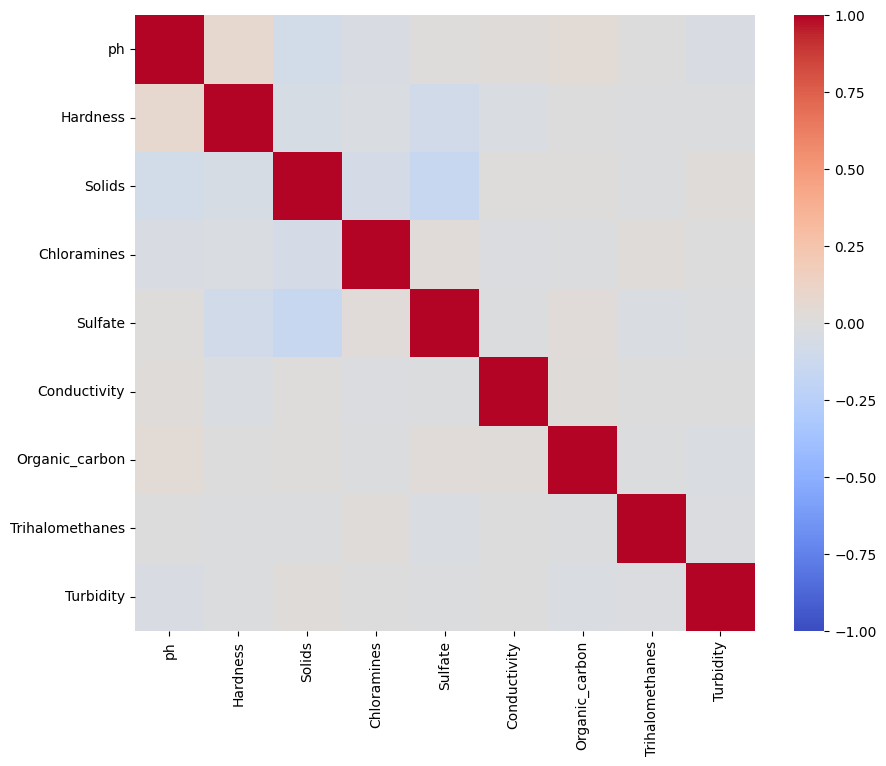

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(num_only.corr(), cmap = 'coolwarm', vmin=-1, vmax=1);

### VIF

VIF rezultat bez skaliranja

In [ ]:
# Izračun VIF-a za sve numeričke varijable (bez 'Potability')
def calculate_vif(data, target_column='Potability', vif_threshold=5):
    # Izuzmi target varijablu
    features = data.drop(columns=[target_column])

    # Izračunaj VIF za svaku numeričku varijablu
    vif_data = pd.DataFrame()
    vif_data["Varijabla"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

    # Identificiraj problematične varijable
    high_vif = vif_data[vif_data["VIF"] > vif_threshold]

    return vif_data, high_vif

# Primjena funkcije
vif_results, high_vif = calculate_vif(df, vif_threshold=5)

print("VIF rezultati:")
print(vif_results)
print("\nVarijable s visokim VIF-om:")
print(high_vif)


VIF rezultati:
         Varijabla        VIF
0               ph  22.848764
1         Hardness  30.841159
2           Solids   6.969471
3      Chloramines  19.586476
4          Sulfate  56.228869
5     Conductivity  25.980361
6   Organic_carbon  18.693990
7  Trihalomethanes  17.367304
8        Turbidity  24.129242

Varijable s visokim VIF-om:
         Varijabla        VIF
0               ph  22.848764
1         Hardness  30.841159
2           Solids   6.969471
3      Chloramines  19.586476
4          Sulfate  56.228869
5     Conductivity  25.980361
6   Organic_carbon  18.693990
7  Trihalomethanes  17.367304
8        Turbidity  24.129242


VIF rezultat skaliranih podataka

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Izračun VIF-a za sve numeričke varijable (bez 'Potability')
def calculate_vif(data, target_column='Potability', vif_threshold=5):
    # Izuzmi target varijablu
    features = data.drop(columns=[target_column])

    # Izračunaj VIF za svaku numeričku varijablu
    vif_data = pd.DataFrame()
    vif_data["Varijabla"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

    # Identificiraj problematične varijable
    high_vif = vif_data[vif_data["VIF"] > vif_threshold]

    return vif_data, high_vif

# Primjena funkcije
vif_results_scaled, high_vif_scaled = calculate_vif(df_scaled, vif_threshold=5)

print("VIF rezultati:")
print(vif_results_scaled)
print("\nVarijable s visokim VIF-om:")
print(high_vif_scaled)


VIF rezultati:
         Varijabla       VIF
0               ph  1.016517
1         Hardness  1.019980
2           Solids  1.039032
3      Chloramines  1.008202
4          Sulfate  1.035747
5     Conductivity  1.002197
6   Organic_carbon  1.004003
7  Trihalomethanes  1.001978
8        Turbidity  1.002982

Varijable s visokim VIF-om:
Empty DataFrame
Columns: [Varijabla, VIF]
Index: []


Zaključaj VIF rezultata je nepouzdan radi mijenjanja rezultata nakon skaliranja, što se u teoriji nebi smijelo događati

In [ ]:
def correlation_detection(dataset, threshold):
    col_corr = set()
    correlated_pairs = []
    dataset = dataset.drop(columns=['Potability'])
    corr_matrix = dataset.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)

    return col_corr

correlated_features = correlation_detection(df_scaled, 0.9)
len(set(correlated_features))

0

In [ ]:
correlated_features = correlation_detection(df, 0.9)
len(set(correlated_features))

0

In [ ]:
def correlated_feature_pairs(dataset, threshold):
    correlated_pairs = []
    dataset = dataset.drop(columns=['Potability'])
    corr_matrix = dataset.corr() # Izračun matrice korelacije

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                correlated_pairs.append((feature1, feature2))

    return correlated_pairs

correlation_threshold = 0.9

correlated_pairs = correlated_feature_pairs(df_scaled, correlation_threshold)

print("Ukupno je pronađeno",len(correlated_pairs),"koreliranih parova.")
print(" ")

for pair in correlated_pairs:
    print(f"Korelirani par: {pair[0]} and {pair[1]}")

Ukupno je pronađeno 0 koreliranih parova.
 


In [ ]:
Q1 = num_only.quantile(0.25)
Q3 = num_only.quantile(0.75)
upper_bounds = Q3 + 1.5*(Q3 - Q1)
lower_bounds = Q1 - 1.5*(Q3 - Q1)

num_outliers = pd.DataFrame(((num_only > upper_bounds) | (num_only < lower_bounds)).sum())
total_instances = len(num_only)
percentage_outliers = pd.DataFrame((num_outliers / total_instances) * 100)

result = pd.concat([num_outliers, percentage_outliers], axis=1)
result.columns = ['Broj stršila', 'Postotak stršila']
result.sort_values(by='Postotak stršila', ascending=False).round(2)

,Broj stršila,Postotak stršila
Sulfate,264,8.06
ph,142,4.33
Hardness,83,2.53
Chloramines,61,1.86
Trihalomethanes,54,1.65
Solids,47,1.43
Organic_carbon,25,0.76
Turbidity,19,0.58
Conductivity,11,0.34


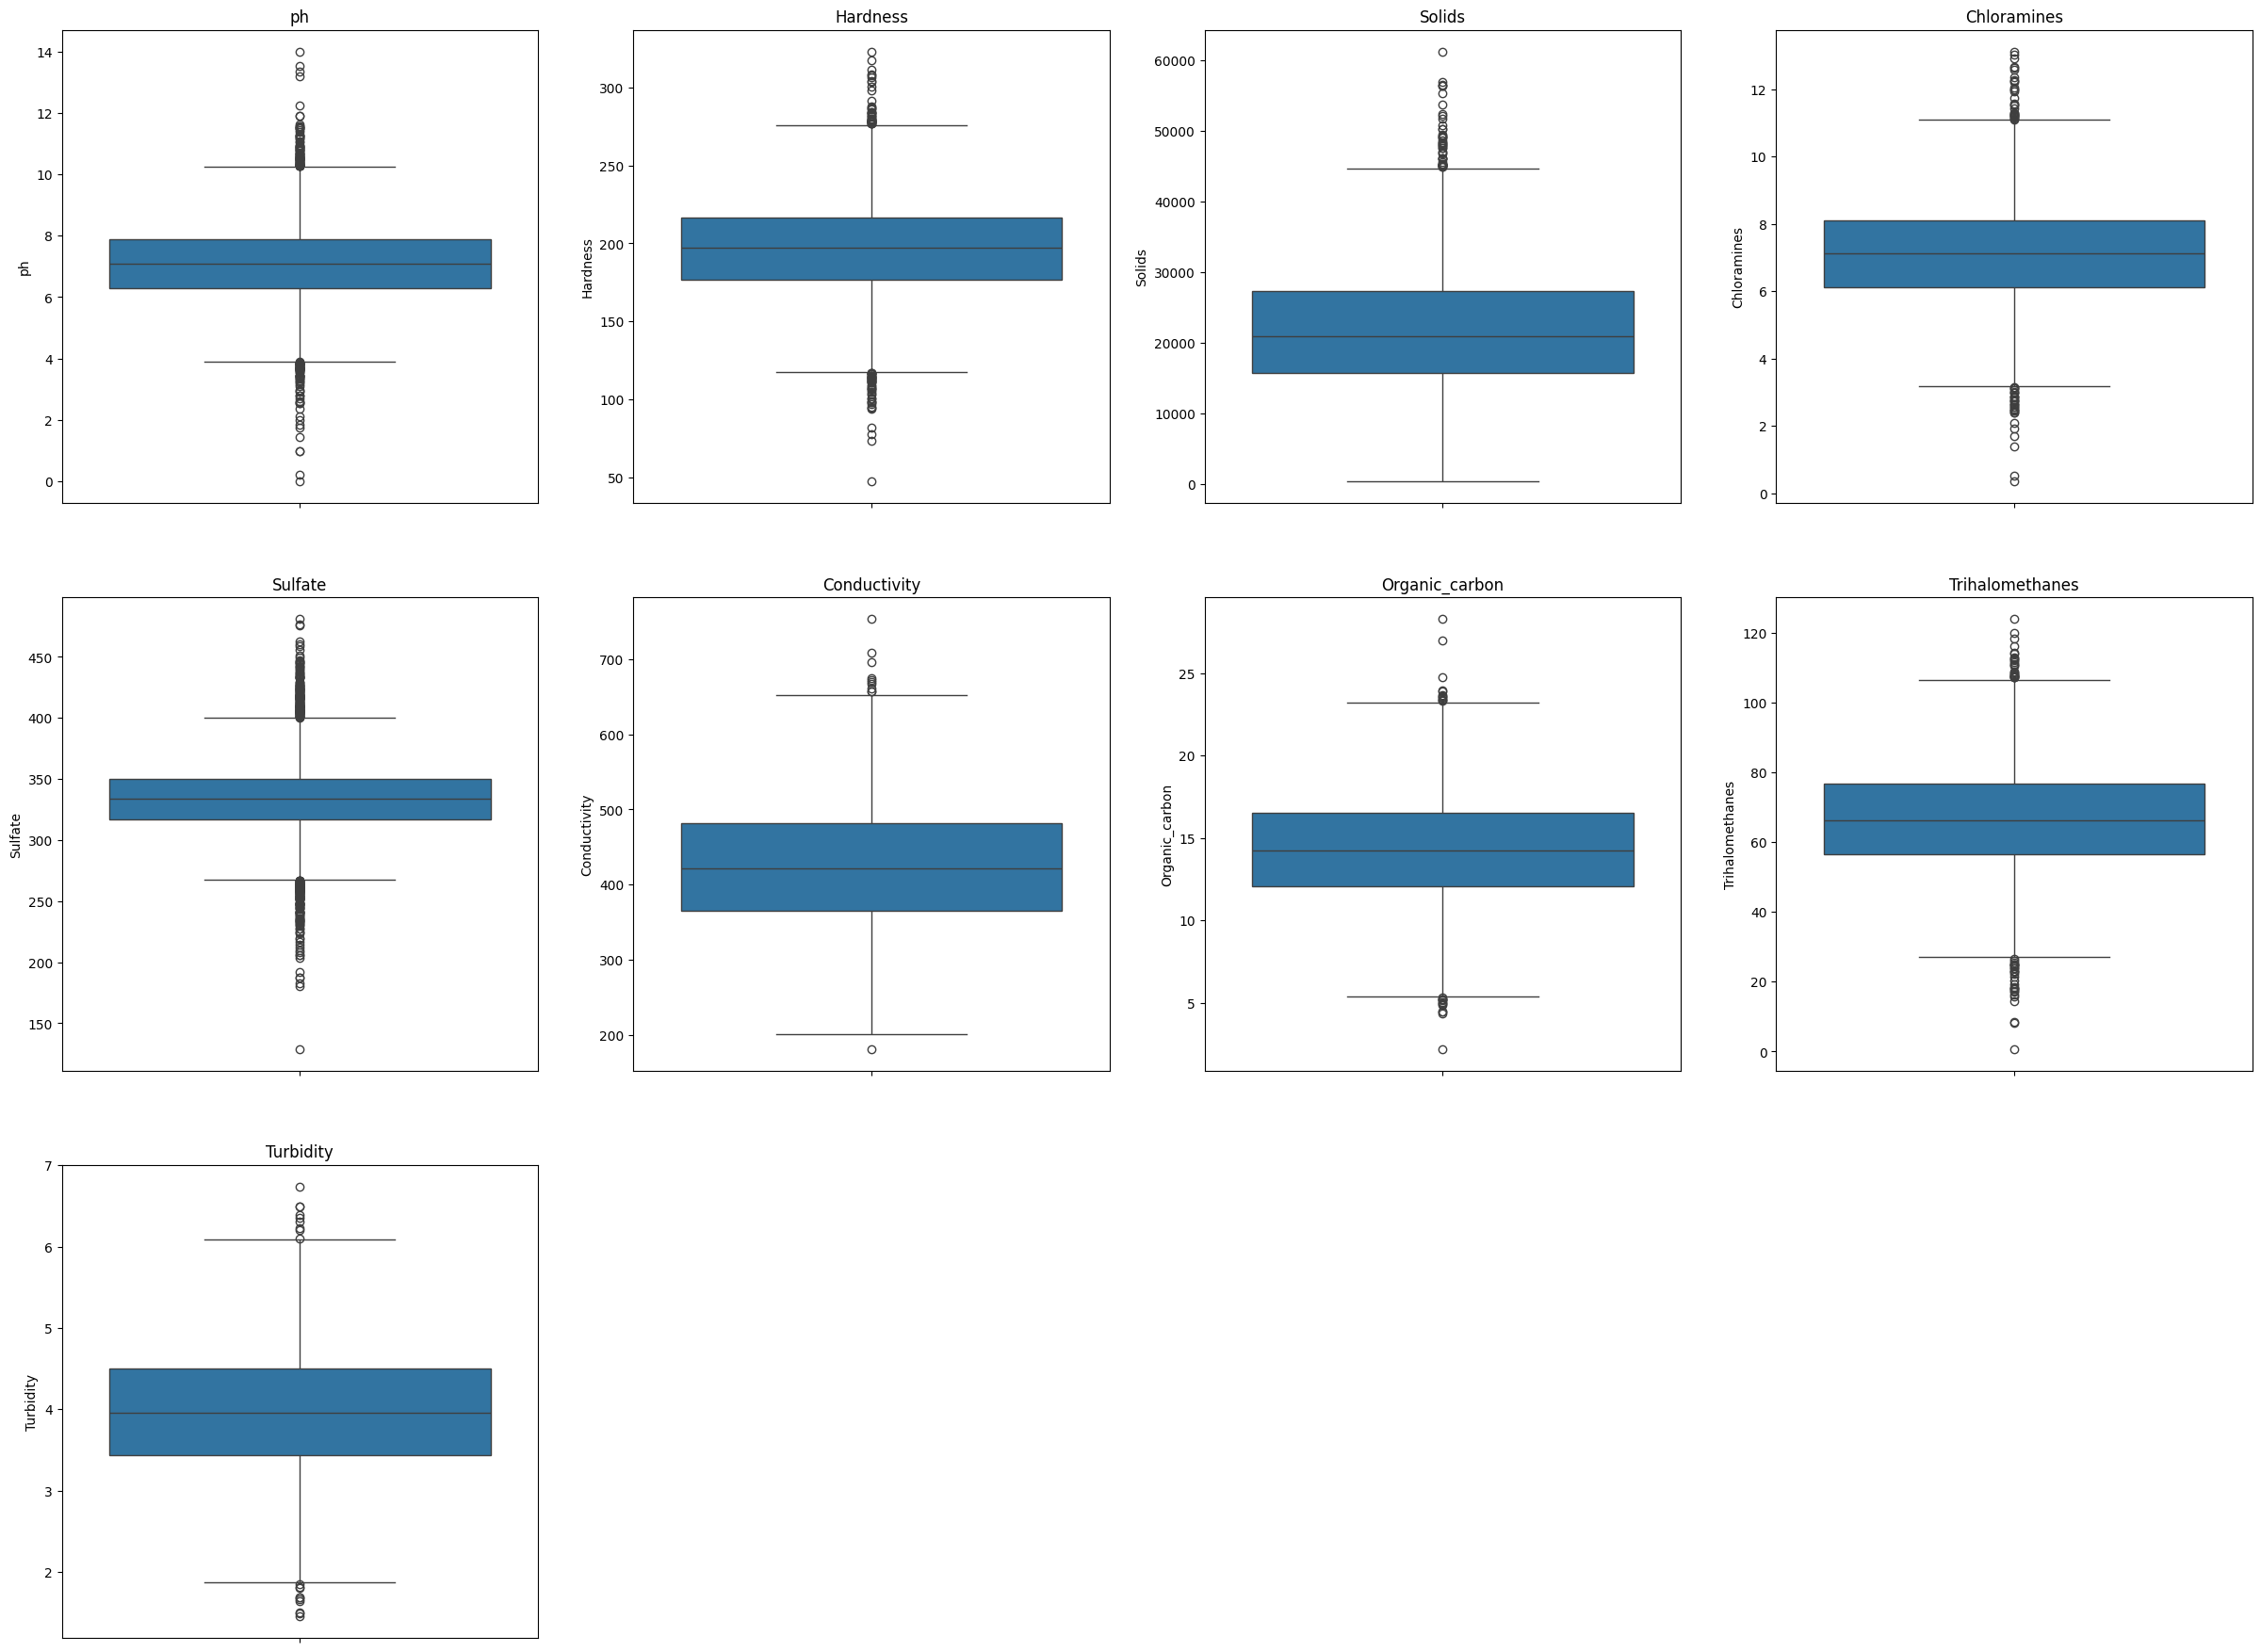

In [ ]:
plt.figure(figsize = (30,30))
for i in range(len(num_only.columns)):
  plt.subplot(4, 4, i+1)
  sns.boxplot(y = num_only.columns[i], data = num_only)
  plt.title(df.columns[i])
plt.tight_layout
plt.show()

In [ ]:
column_to_analyze = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

data2 = num_only.copy()
for column in column_to_analyze:
  Q2 = num_only[column].quantile(0.50)
  data2.loc[data2[column] < lower_bounds[column], column] = Q2
  data2.loc[data2[column] > upper_bounds[column], column] = Q2

outliers_count = ((num_only < lower_bounds) | (num_only > upper_bounds)).any(axis=1).sum()
print(f"Broj redaka s barem jednim stršilom: {outliers_count}")

outliers_after = ((data2 < lower_bounds) | (data2 > upper_bounds)).any(axis=1).sum()
print(f"Broj redaka s barem jednim stršilom nakon obrade: {outliers_after}")

Broj redaka s barem jednim stršilom: 610
Broj redaka s barem jednim stršilom nakon obrade: 0


In [ ]:
Q1 = num_only.quantile(0.25)
Q3 = num_only.quantile(0.75)
upper_bounds = Q3 + 1.5*(Q3 - Q1)
lower_bounds = Q1 - 1.5*(Q3 - Q1)

num_outliers = pd.DataFrame(((data2 > upper_bounds) | (data2 < lower_bounds)).sum())
total_instances = len(data2)
percentage_outliers = pd.DataFrame((num_outliers / total_instances) * 100)

result = pd.concat([num_outliers, percentage_outliers], axis=1)
result.columns = ['Broj stršila', 'Postotak stršila']
result.sort_values(by='Postotak stršila', ascending=False).round(2)

,Broj stršila,Postotak stršila
ph,0,0.0
Hardness,0,0.0
Solids,0,0.0
Chloramines,0,0.0
Sulfate,0,0.0
Conductivity,0,0.0
Organic_carbon,0,0.0
Trihalomethanes,0,0.0
Turbidity,0,0.0


In [ ]:
data2['Potability'] = df['Potability']

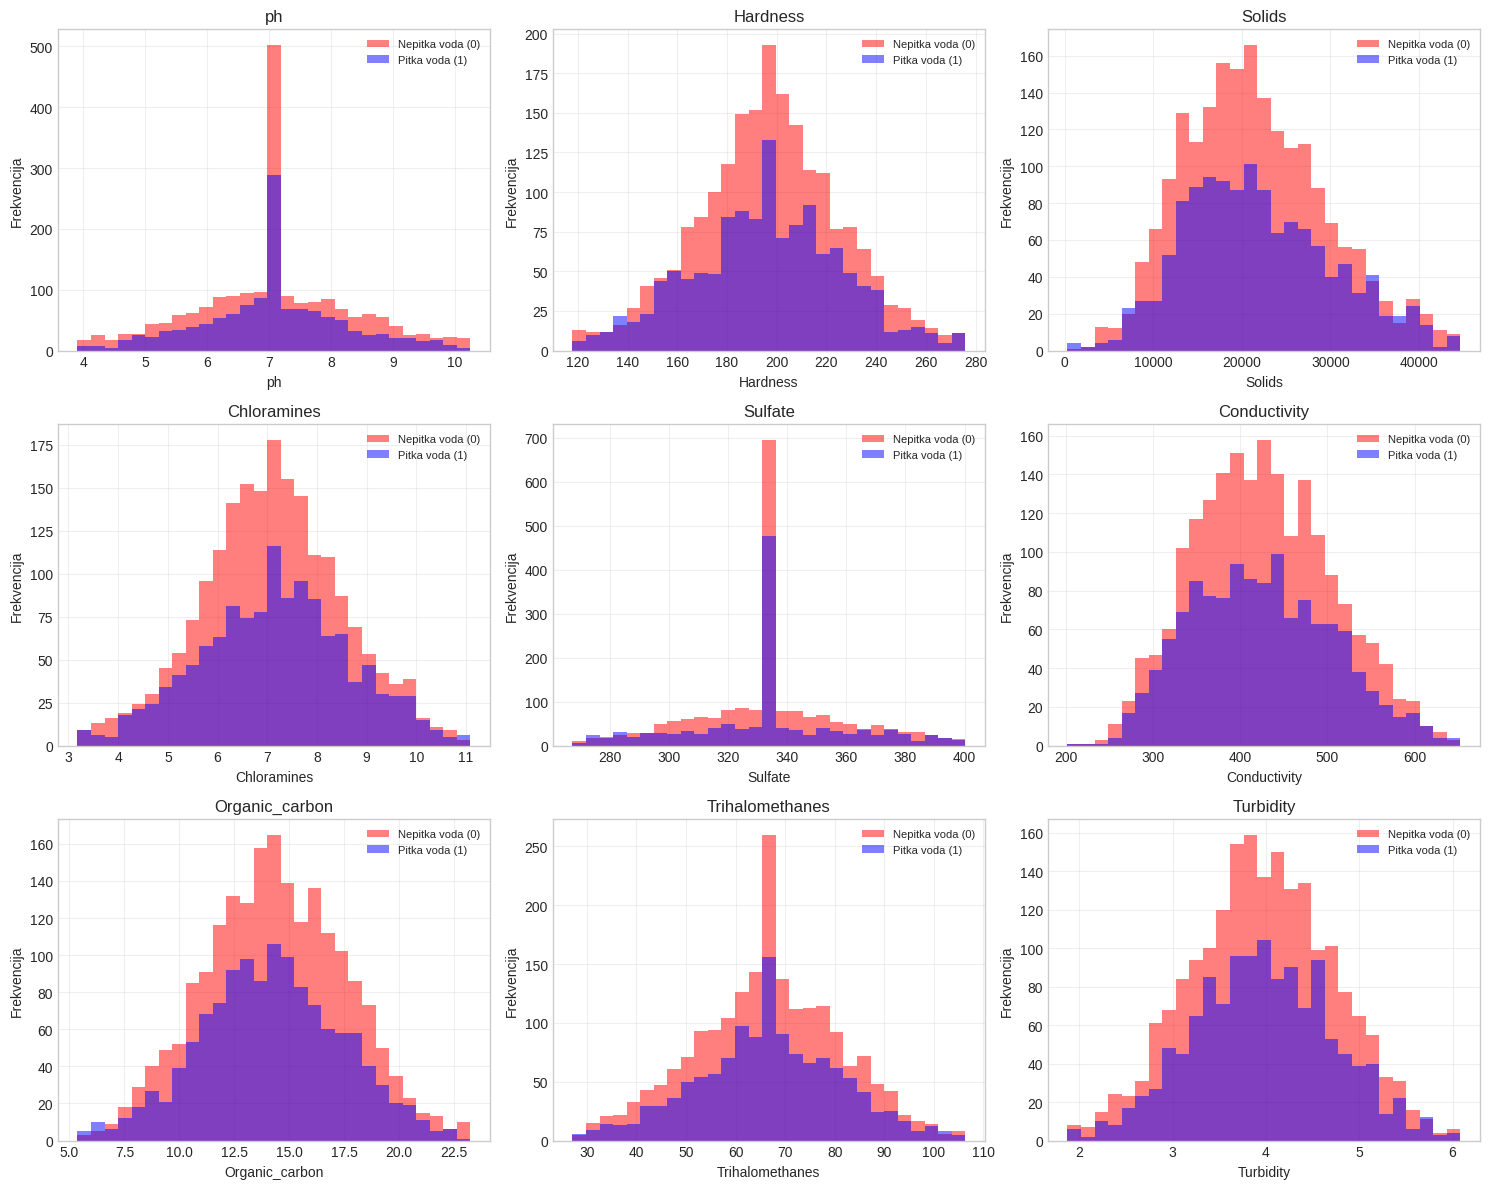

In [ ]:
# Postavljanje stila
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set1")

# Funkcija za crtanje preklapajućih histograma u subplotovima
def plot_overlapping_histograms_subplots(df, features, n_cols=3):
    # Izračun potrebnog broja redova
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols

    # Kreiranje figure i subplotova
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # Pretvaranje u 1D niz za lakše iteriranje

    for i, feature in enumerate(features):
        ax = axes[i]
        # Razdvajanje podataka na pitku i nepitku vodu
        pitka = df[df['Potability'] == 1][feature]
        nepitka = df[df['Potability'] == 0][feature]

        # Određivanje zajedničkih granica za histograme
        min_val = min(pitka.min(), nepitka.min())
        max_val = max(pitka.max(), nepitka.max())
        bins = np.linspace(min_val, max_val, 30)

        # Crtanje histograma na trenutnom subplotu
        ax.hist(nepitka, bins=bins, alpha=0.5, label='Nepitka voda (0)', color='red')
        ax.hist(pitka, bins=bins, alpha=0.5, label='Pitka voda (1)', color='blue')

        ax.set_title(f'{feature}', fontsize=12)
        ax.set_xlabel(feature, fontsize=10)
        ax.set_ylabel('Frekvencija', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # Uklanjanje praznih subplotova ako ih ima
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Definiranje značajki
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
            'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# Poziv funkcije za crtanje - 3 grafa po redu
plot_overlapping_histograms_subplots(df_scaled, features, n_cols=3)


In [ ]:
class_distribution = df['Potability'].value_counts()
print(class_distribution)

# Izračun postotka uzoraka po klasi
class_percentage = df['Potability'].value_counts(normalize=True) * 100
print(class_percentage)


Potability
0    1998
1    1278
Name: count, dtype: int64
Potability
0    60.989011
1    39.010989
Name: proportion, dtype: float64


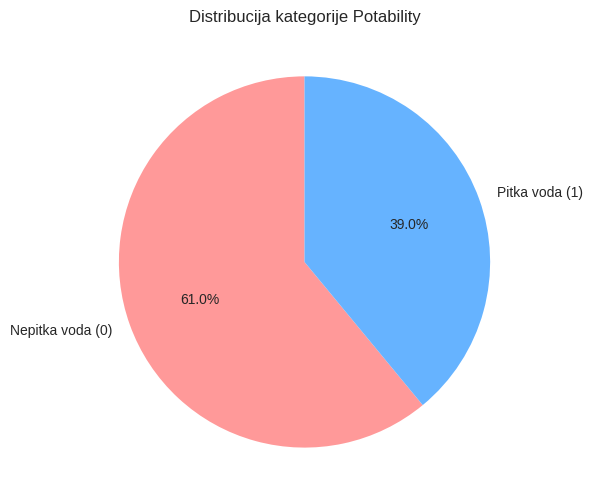

In [ ]:
labels = ['Nepitka voda (0)', 'Pitka voda (1)']
counts = df['Potability'].value_counts().sort_index()

# Crtanje pie charta
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Distribucija kategorije Potability')
plt.tight_layout()
#plt.savefig("Distribucija.png")
plt.show()

# Funkcije

In [ ]:
def print_grid_search_results(grid_search):
    print("Rezultati Grid Search optimizacije hiperparametara:")
    print("Najbolji parametri:", grid_search.best_params_)
    print("Najbolja točnost (accuracy): {:.4f}".format(grid_search.best_score_))

In [ ]:
def robust_binning(df, columns, max_categories=5):
    df_result = df.copy()

    for column in columns:
        print(f"\n=== Obrađujem {column} ===")

        # Provjeri broj jedinstvenih vrijednosti
        unique_values = df_result[column].nunique()

        if unique_values <= max_categories:
            # Ako ima malo jedinstvenih vrijednosti, koristi ih direktno
            df_result[f'{column}_binned'] = df_result[column].astype('category')
            print(f"{column}: {unique_values} prirodnih kategorija")

        else:
            # Pokušaj s kvantilima
            try:
                df_result[f'{column}_binned'] = pd.qcut(
                    df_result[column],
                    q=max_categories,
                    labels=[f'{column}_Q{i+1}' for i in range(max_categories)],
                    duplicates='drop'
                )
                actual_cats = df_result[f'{column}_binned'].nunique()
                print(f"{column}: {actual_cats} kvantilnih kategorija")

            except (ValueError, TypeError):
                # Fallback na jednake intervale
                min_val = df_result[column].min()
                max_val = df_result[column].max()

                # Dodaj malu vrijednost da rješiš probleme s granicama
                epsilon = (max_val - min_val) * 0.001
                bins = np.linspace(min_val - epsilon, max_val + epsilon, max_categories + 1)

                df_result[f'{column}_binned'] = pd.cut(
                    df_result[column],
                    bins=bins,
                    labels=[f'{column}_B{i+1}' for i in range(max_categories)]
                )
                print(f"{column}: {max_categories} jednakih intervala")

    return df_result


In [ ]:
def prikazi_binning_info(df, features, max_categories=5):
    df_binned = robust_binning(df, features, max_categories)
    print("\n=== FINALNI REZULTATI ===")
    for feature in features:
        binned_col = f'{feature}_binned'
        n_cats = df_binned[binned_col].nunique()
        print(f"{feature}: {n_cats} kategorija")
    return df_binned

In [ ]:
def prikazi_vaznost_znacajki(model, X):
    importances = model.named_steps['classifier'].feature_importances_
    feature_importances = pd.DataFrame({
        'Značajka': X.columns,
        'Važnost': importances
    }).sort_values(by='Važnost', ascending=False)
    print(feature_importances)

In [ ]:
def prikazi_top_znacajke(model, X, palette="viridis", return_data=False):
    importances = model.named_steps['classifier'].feature_importances_
    feature_names = X.columns

    feature_importance = pd.DataFrame({
        "Značajka": feature_names,
        "Važnost": importances
    }).sort_values(by="Važnost", ascending=False)

    if return_data:
        return feature_importance

    else:
        feature_importance["Boja"] = feature_importance["Značajka"]

        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=feature_importance,
            x="Važnost",
            y="Značajka",
            hue="Boja",
            dodge=False,
            palette=palette,
            legend=False
        )
        plt.title("Važnost značajki")
        plt.xlabel("Važnost")
        plt.ylabel("Značajke")
        plt.tight_layout()
        plt.show()


In [ ]:
def prikazi_evaluacijske_grafove(model, X_test, y_test, naziv_modela="Model"):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Evaluacija: {naziv_modela}", fontsize=16)

    # 1. Matrica zabune
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axs[0], cmap='Blues', values_format='d')
    axs[0].set_title("Matrica konfuzije")

    # 2. ROC krivulja
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axs[1])
    axs[1].set_title("ROC krivulja")

    # 3. Preciznost i odziv po klasama
    df_report[['precision', 'recall']].iloc[:-1].plot(kind='bar', ax=axs[2])
    axs[2].set_title("Preciznost i odziv")
    axs[2].set_ylabel("Vrijednost")
    axs[2].set_xticklabels(df_report.index[:-1], rotation=45)
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def evaluiraj_model(model, X_test, y_test, grid_search=None, naziv_modela="Model"):
    y_pred = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)

    print(f"\nTočnost modela ({naziv_modela}) na test skupu: {test_accuracy:.4f}")
    print("\nDetaljan izvještaj:")
    print(classification_report(y_test, y_pred))

    if grid_search is not None:
        print("\nGrid Search rezultati:")
        print_grid_search_results(grid_search)

# Modeliranje

## RF1 - Random Forest s normalizacijom

Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Točnost modela (Random Forest 1) na test skupu: 0.6723

Detaljan izvještaj:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77       400
           1       0.67      0.32      0.43       256

    accuracy                           0.67       656
   macro avg       0.67      0.61      0.60       656
weighted avg       0.67      0.67      0.64       656


Grid Search rezultati:
Rezultati Grid Search optimizacije hiperparametara:
Najbolji parametri: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 179}
Najbolja točnost (accuracy): 0.6817


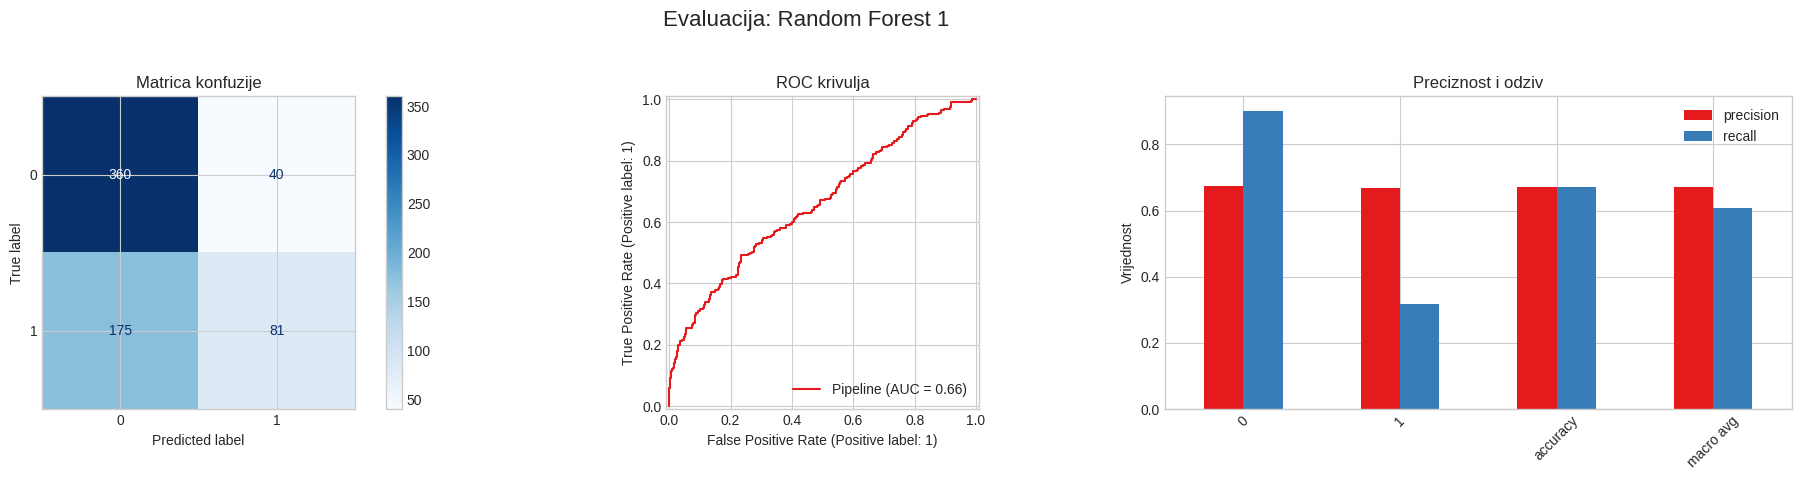

In [ ]:
X = df.drop('Potability', axis=1)
y = df["Potability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definiranje modela
rf = RandomForestClassifier(random_state=42)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier',  RandomForestClassifier(random_state=42))
])

# Definiranje mreže hiperparametara za Grid Search
param_grid = {
    'classifier__n_estimators': [177, 178, 179],
    'classifier__max_depth': [None, 1, 2],
    'classifier__min_samples_split': [7, 8, 9],
    'classifier__min_samples_leaf': [2, 3, 4],
    'classifier__bootstrap': [True],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

# K-fold unakrsna validacija
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search s k-fold
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Evaluacija najboljeg modela na test skupu
best_model = grid_search.best_estimator_

evaluiraj_model(best_model, X_test, y_test, grid_search=grid_search, naziv_modela="Random Forest 1")
prikazi_evaluacijske_grafove(best_model, X_test, y_test, naziv_modela="Random Forest 1")


          Značajka   Važnost
0               ph  0.137077
4          Sulfate  0.134144
1         Hardness  0.122720
3      Chloramines  0.116497
2           Solids  0.114900
5     Conductivity  0.096751
6   Organic_carbon  0.093431
7  Trihalomethanes  0.092785
8        Turbidity  0.091694


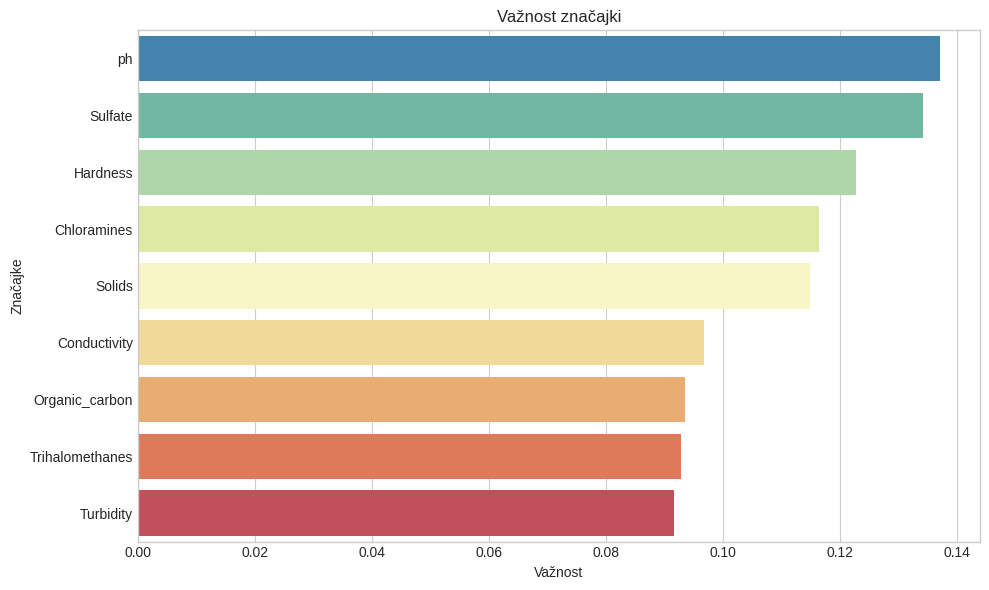

In [ ]:
prikazi_vaznost_znacajki(best_model, X)
prikazi_top_znacajke(best_model, X, palette="Spectral_r",return_data=False)

## RF2 - Random Forest s odbačenim značajkama iz feature importance

In [ ]:
feature_importances = prikazi_top_znacajke(best_model, X, return_data=True)

important_features = feature_importances[feature_importances['Važnost'] > 0.1]
print(important_features)

      Značajka   Važnost
0           ph  0.137077
4      Sulfate  0.134144
1     Hardness  0.122720
3  Chloramines  0.116497
2       Solids  0.114900


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Točnost modela (Random Forest 2) na test skupu: 0.6677

Detaljan izvještaj:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       400
           1       0.63      0.36      0.46       256

    accuracy                           0.67       656
   macro avg       0.65      0.61      0.61       656
weighted avg       0.66      0.67      0.64       656


Grid Search rezultati:
Rezultati Grid Search optimizacije hiperparametara:
Najbolji parametri: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 341}
Najbolja točnost (accuracy): 0.6874


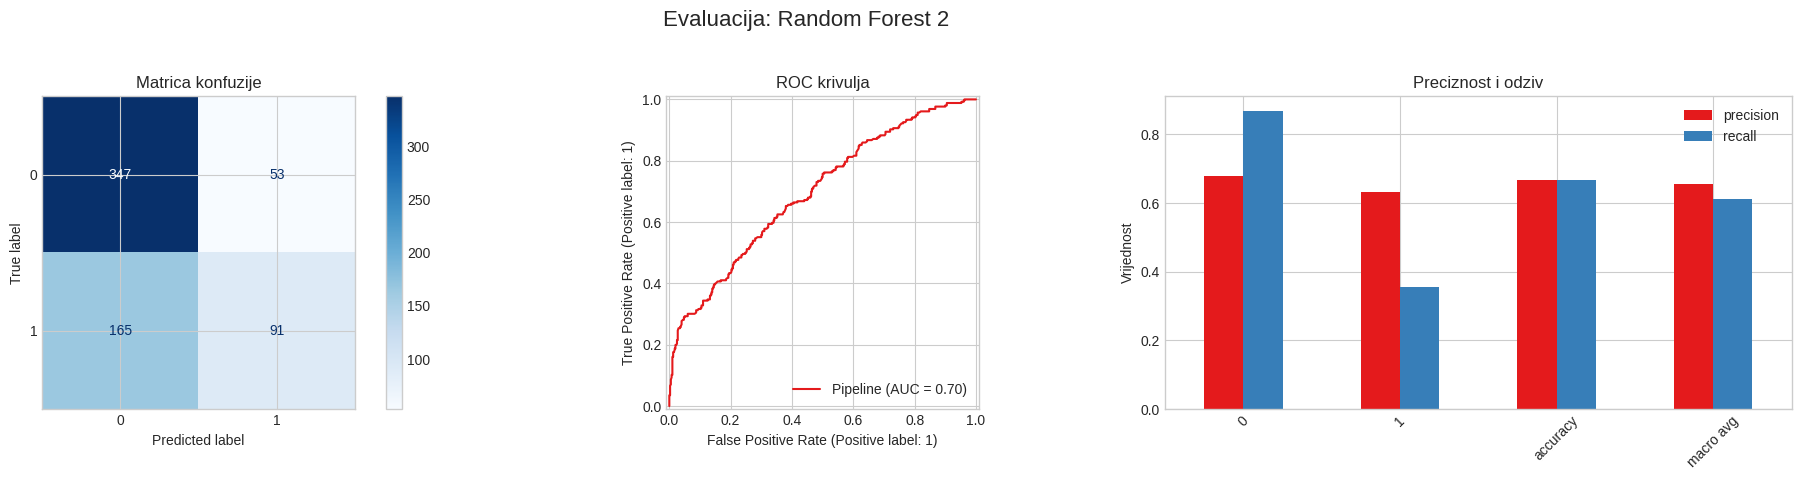

In [ ]:
X = df[important_features["Značajka"]]
y = df["Potability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definiranje modela - isti kod kao prije
rf = RandomForestClassifier(random_state=42)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier',  RandomForestClassifier(random_state=42))
])


# Definiranje mreže hiperparametara za Grid Search
param_grid = {
    'classifier__n_estimators': [339, 340, 341],
    'classifier__max_depth': [None, 25, 30],
    'classifier__min_samples_split': [2, 3],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

# K-fold unakrsna validacija
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search s k-fold
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Evaluacija najboljeg modela na test skupu
best_model = grid_search.best_estimator_
evaluiraj_model(best_model, X_test, y_test, grid_search=grid_search, naziv_modela="Random Forest 2")
prikazi_evaluacijske_grafove(best_model, X_test, y_test, naziv_modela="Random Forest 2")


      Značajka   Važnost
2     Hardness  0.206720
0           ph  0.202563
3  Chloramines  0.200963
1      Sulfate  0.196160
4       Solids  0.193594


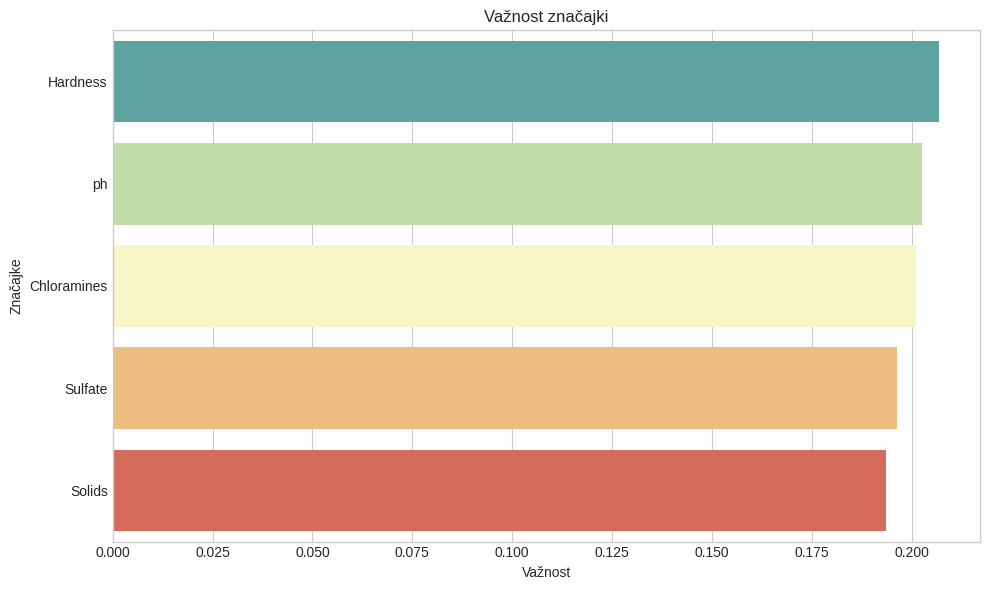

In [ ]:
prikazi_vaznost_znacajki(best_model, X)
prikazi_top_znacajke(best_model, X, palette="Spectral_r",return_data=False)

## RF3 - Random Forest s kategoričnim vrijednostima (5 kategorija)

In [ ]:
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
           'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

df_binned = prikazi_binning_info(df, features, max_categories=5)


=== Obrađujem ph ===
ph: 5 kvantilnih kategorija

=== Obrađujem Hardness ===
Hardness: 5 kvantilnih kategorija

=== Obrađujem Solids ===
Solids: 5 kvantilnih kategorija

=== Obrađujem Chloramines ===
Chloramines: 5 kvantilnih kategorija

=== Obrađujem Sulfate ===
Sulfate: 5 jednakih intervala

=== Obrađujem Conductivity ===
Conductivity: 5 kvantilnih kategorija

=== Obrađujem Organic_carbon ===
Organic_carbon: 5 kvantilnih kategorija

=== Obrađujem Trihalomethanes ===
Trihalomethanes: 5 kvantilnih kategorija

=== Obrađujem Turbidity ===
Turbidity: 5 kvantilnih kategorija

=== FINALNI REZULTATI ===
ph: 5 kategorija
Hardness: 5 kategorija
Solids: 5 kategorija
Chloramines: 5 kategorija
Sulfate: 5 kategorija
Conductivity: 5 kategorija
Organic_carbon: 5 kategorija
Trihalomethanes: 5 kategorija
Turbidity: 5 kategorija


Kategorijske varijable: ['ph_binned', 'Hardness_binned', 'Solids_binned', 'Chloramines_binned', 'Sulfate_binned', 'Conductivity_binned', 'Organic_carbon_binned', 'Trihalomethanes_binned', 'Turbidity_binned']
Numeričke varijable: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Točnost modela (Random Forest 3) na test skupu: 0.6738

Detaljan izvještaj:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       400
           1       0.66      0.33      0.44       256

    accuracy                           0.67       656
   macro avg       0.67      0.61      0.61       656
weighted avg       0.67      0.67      0.64       656


Grid Search rezultati:
Rezultati Grid Search optimizacije hiperparametara:
Najbolji parametri: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_dept

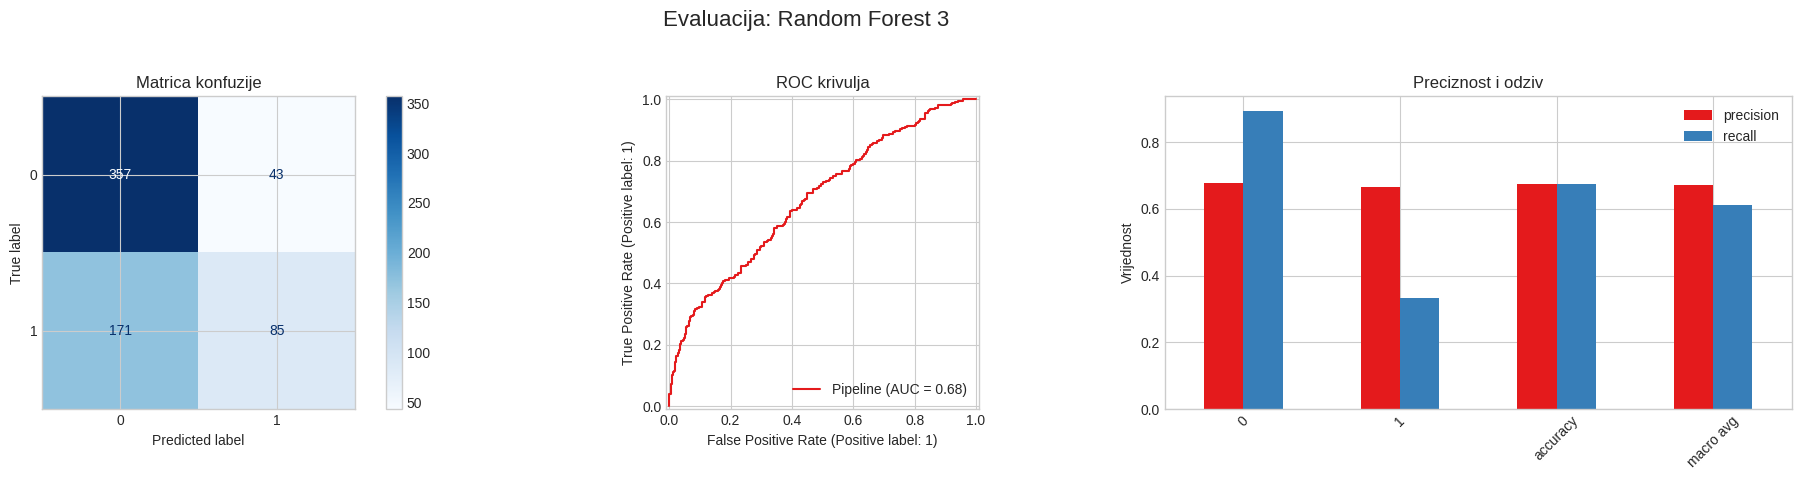

In [ ]:
categorical_features = df_binned.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Potability' in categorical_features:
    categorical_features.remove('Potability')

numerical_features = df_binned.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Potability' in numerical_features:
    numerical_features.remove('Potability')

print(f"Kategorijske varijable: {categorical_features}")
print(f"Numeričke varijable: {numerical_features}")

# Pipeline s preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

pipeline_advanced = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


# Prilagođeni param_grid za pipeline s preprocessorom
param_grid_advanced = {
    'classifier__n_estimators': [190, 200, 210],
    'classifier__max_depth': [16, 14, 15, None],
    'classifier__min_samples_split': [2, 3],
    'classifier__min_samples_leaf': [1, 2,],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None],
    'classifier__bootstrap': [True]
}

X = df_binned.drop('Potability', axis=1)
y = df_binned["Potability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search_advanced = GridSearchCV(
    pipeline_advanced,
    param_grid_advanced,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_advanced.fit(X_train, y_train)

# Evaluacija najboljeg modela na test skupu
best_model = grid_search_advanced.best_estimator_
evaluiraj_model(best_model, X_test, y_test, grid_search=grid_search, naziv_modela="Random Forest 3")
prikazi_evaluacijske_grafove(best_model, X_test, y_test, naziv_modela="Random Forest 3")

                  Značajka   Važnost
13          Sulfate_binned  0.108683
9                ph_binned  0.105108
10         Hardness_binned  0.095199
12      Chloramines_binned  0.092818
11           Solids_binned  0.086448
14     Conductivity_binned  0.077451
17        Turbidity_binned  0.074113
16  Trihalomethanes_binned  0.072787
15   Organic_carbon_binned  0.072698
0                       ph  0.032412
2                   Solids  0.026270
3              Chloramines  0.024603
1                 Hardness  0.024568
6           Organic_carbon  0.021903
4                  Sulfate  0.021689
8                Turbidity  0.021344
7          Trihalomethanes  0.020987
5             Conductivity  0.020920


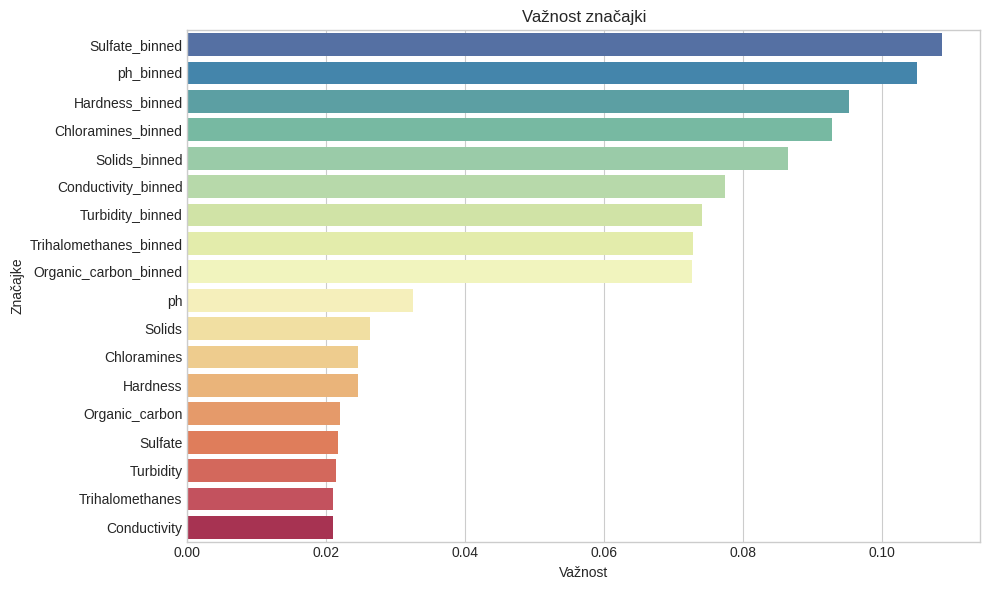

In [ ]:
prikazi_vaznost_znacajki(best_model, X)
prikazi_top_znacajke(best_model, X, palette="Spectral_r",return_data=False)

## RF4 - Random Forest s SMOTE subsampling na _train skupu podataka

Counter({0: 1598, 1: 1022})
Distribucija nakon SMOTE-a:
Counter({0: 1598, 1: 1598})
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Točnost modela (Random Forest 4) na test skupu: 0.6418

Detaljan izvještaj:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       400
           1       0.54      0.50      0.52       256

    accuracy                           0.64       656
   macro avg       0.62      0.62      0.62       656
weighted avg       0.64      0.64      0.64       656


Grid Search rezultati:
Rezultati Grid Search optimizacije hiperparametara:
Najbolji parametri: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 450}
Najbolja točnost (accuracy): 0.7256


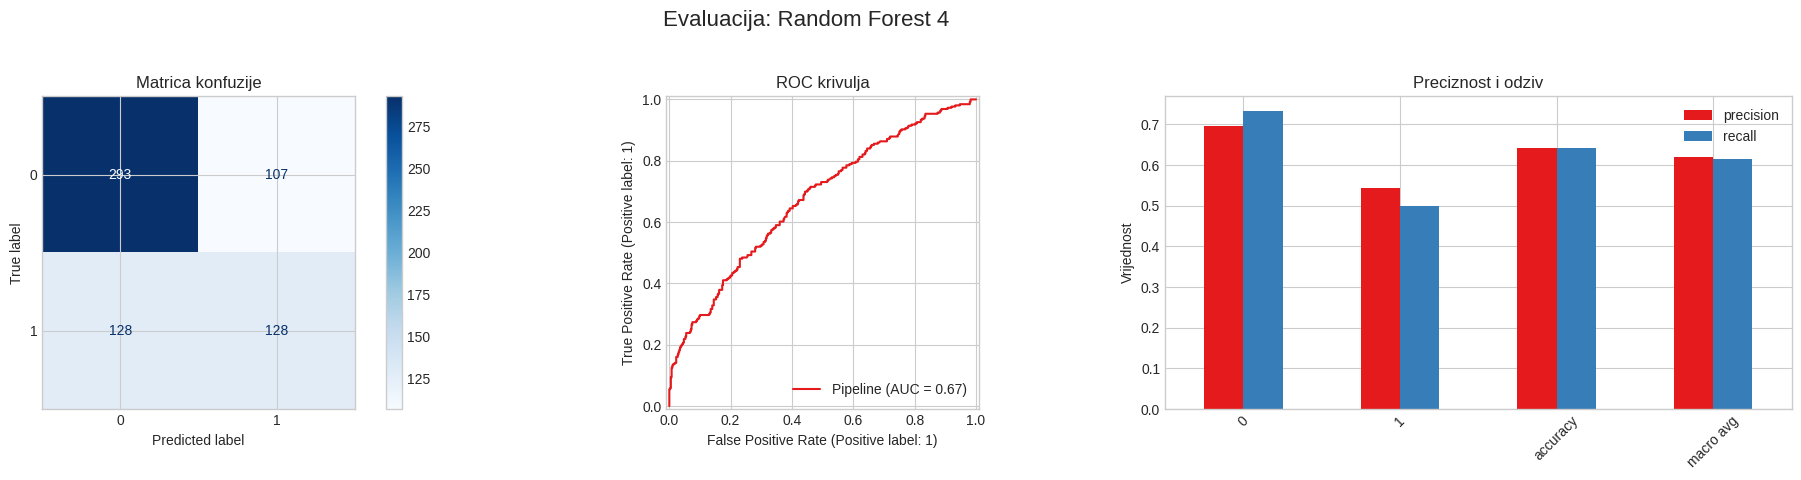

In [ ]:
X = df.drop('Potability', axis=1)
y = df["Potability"]

smote = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(Counter(y_train))

X_train, y_train = smote.fit_resample(X_train, y_train)

print("Distribucija nakon SMOTE-a:")
print(Counter(y_train))

# Definiranje modela - isti kod kao prije
rf = RandomForestClassifier(random_state=42)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier',  RandomForestClassifier(random_state=42))
])


# Definiranje mreže hiperparametara za Grid Search
param_grid = {
    'classifier__n_estimators': [425, 450, 475],
    'classifier__max_depth': [None, 2,3,4],
    'classifier__min_samples_split': [2, 3],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

# K-fold unakrsna validacija
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search s k-fold
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Evaluacija najboljeg modela na test skupu
best_model = grid_search.best_estimator_
evaluiraj_model(best_model, X_test, y_test, grid_search=grid_search, naziv_modela="Random Forest 4")
prikazi_evaluacijske_grafove(best_model, X_test, y_test, naziv_modela="Random Forest 4")


          Značajka   Važnost
0               ph  0.133021
4          Sulfate  0.122487
2           Solids  0.120210
3      Chloramines  0.116001
1         Hardness  0.114878
5     Conductivity  0.100349
8        Turbidity  0.099067
6   Organic_carbon  0.097596
7  Trihalomethanes  0.096392


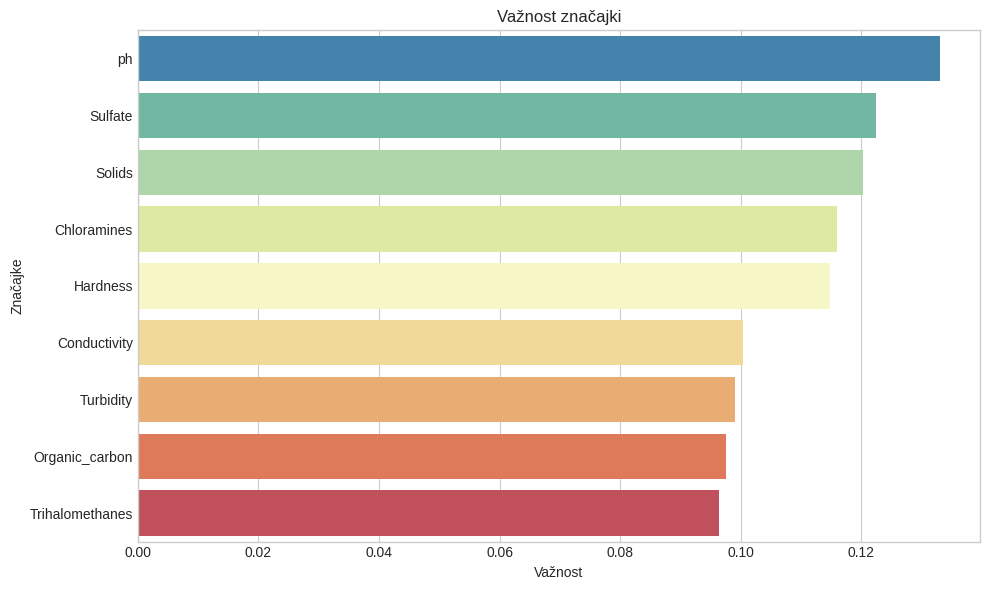

In [ ]:
prikazi_vaznost_znacajki(best_model, X)
prikazi_top_znacajke(best_model, X, palette="Spectral_r",return_data=False)

## RF5 - Random Forest s SMOTE subsampling na cijelom skupu podataka

Originalna distribucija:
Counter({0: 1998, 1: 1278})
Distribucija nakon SMOTE-a:
Counter({0: 1998, 1: 1998})
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Točnost modela (Random Forest 5) na test skupu: 0.7075

Detaljan izvještaj:
              precision    recall  f1-score   support

           0       0.69      0.74      0.72       400
           1       0.72      0.67      0.70       400

    accuracy                           0.71       800
   macro avg       0.71      0.71      0.71       800
weighted avg       0.71      0.71      0.71       800


Grid Search rezultati:
Rezultati Grid Search optimizacije hiperparametara:
Najbolji parametri: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Najbolja točnost (accuracy): 0.6993


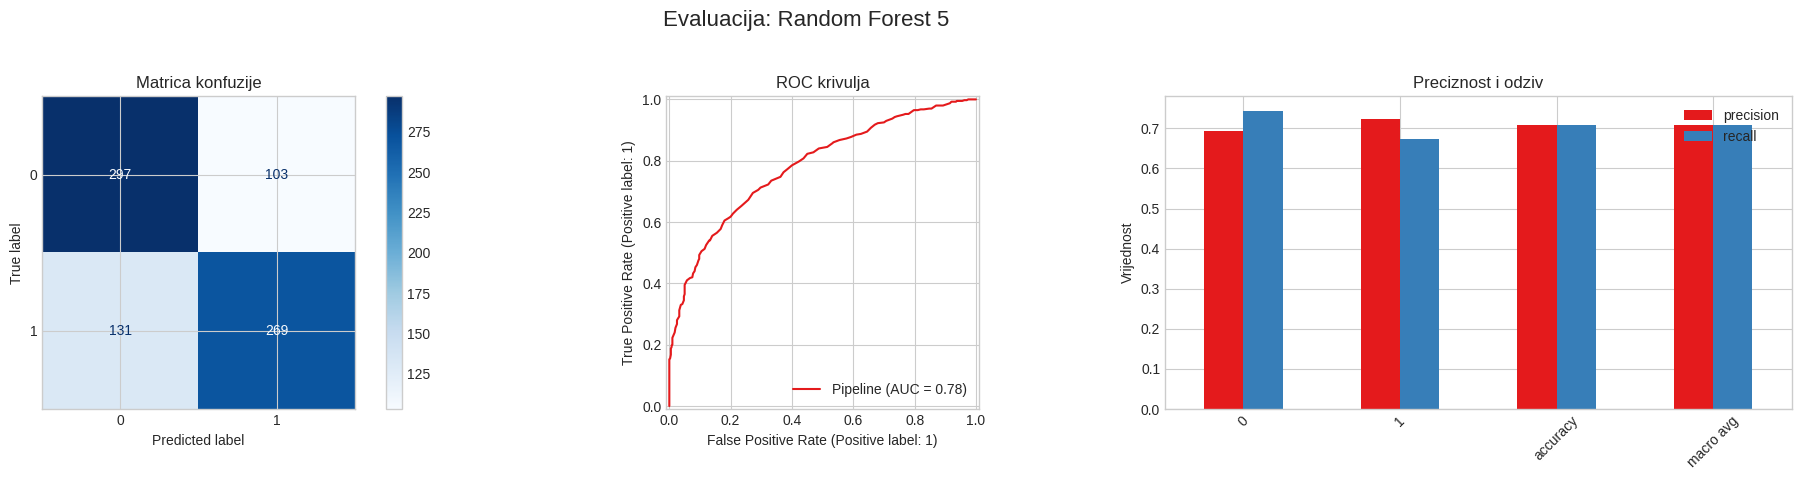

In [ ]:
X = df.drop('Potability', axis=1)
y = df["Potability"]

print("Originalna distribucija:")
print(Counter(y))

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

print("Distribucija nakon SMOTE-a:")
print(Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definiranje modela - isti kod kao prije
rf = RandomForestClassifier(random_state=42)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier',  RandomForestClassifier(random_state=42))
])


# Definiranje mreže hiperparametara za Grid Search
param_grid = {
    'classifier__n_estimators': [190, 200, 210],
    'classifier__max_depth': [None, 2,3,4],
    'classifier__min_samples_split': [2, 3],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

# K-fold unakrsna validacija
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search s k-fold
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Evaluacija najboljeg modela na test skupu
best_model = grid_search.best_estimator_
evaluiraj_model(best_model, X_test, y_test, grid_search=grid_search, naziv_modela="Random Forest 5")
prikazi_evaluacijske_grafove(best_model, X_test, y_test, naziv_modela="Random Forest 5")


          Značajka   Važnost
0               ph  0.135582
2           Solids  0.120618
4          Sulfate  0.118066
1         Hardness  0.114006
3      Chloramines  0.112370
5     Conductivity  0.102566
8        Turbidity  0.102085
6   Organic_carbon  0.097678
7  Trihalomethanes  0.097029


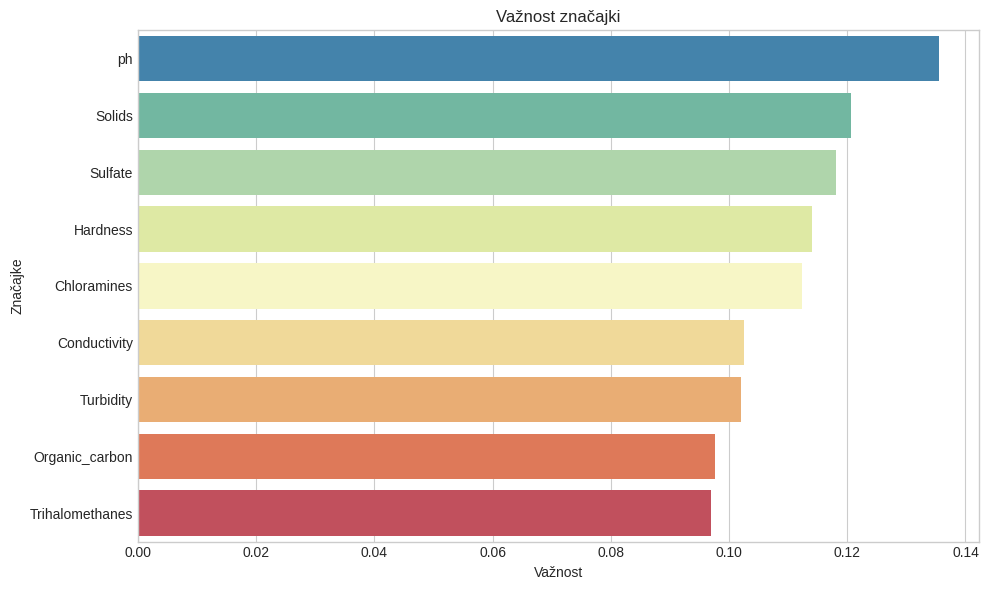

In [ ]:
prikazi_vaznost_znacajki(best_model, X)
prikazi_top_znacajke(best_model, X, palette="Spectral_r",return_data=False)

## RF6 - Random Forest sa SMOTE subsamplingom na cijelom skupu podataka i kategorizacijom (5 kategorija)

In [ ]:
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
           'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

df_binned = prikazi_binning_info(df, features, max_categories=5)


=== Obrađujem ph ===
ph: 5 kvantilnih kategorija

=== Obrađujem Hardness ===
Hardness: 5 kvantilnih kategorija

=== Obrađujem Solids ===
Solids: 5 kvantilnih kategorija

=== Obrađujem Chloramines ===
Chloramines: 5 kvantilnih kategorija

=== Obrađujem Sulfate ===
Sulfate: 5 jednakih intervala

=== Obrađujem Conductivity ===
Conductivity: 5 kvantilnih kategorija

=== Obrađujem Organic_carbon ===
Organic_carbon: 5 kvantilnih kategorija

=== Obrađujem Trihalomethanes ===
Trihalomethanes: 5 kvantilnih kategorija

=== Obrađujem Turbidity ===
Turbidity: 5 kvantilnih kategorija

=== FINALNI REZULTATI ===
ph: 5 kategorija
Hardness: 5 kategorija
Solids: 5 kategorija
Chloramines: 5 kategorija
Sulfate: 5 kategorija
Conductivity: 5 kategorija
Organic_carbon: 5 kategorija
Trihalomethanes: 5 kategorija
Turbidity: 5 kategorija


Kategorijske varijable: ['ph_binned', 'Hardness_binned', 'Solids_binned', 'Chloramines_binned', 'Sulfate_binned', 'Conductivity_binned', 'Organic_carbon_binned', 'Trihalomethanes_binned', 'Turbidity_binned']
Numeričke varijable: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
Originalna distribucija:
Counter({0: 1998, 1: 1278})
Distribucija nakon SMOTENC-a:
Counter({0: 1998, 1: 1998})
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Točnost modela (Random Forest 6) na test skupu: 0.7362

Detaljan izvještaj:
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       400
           1       0.79      0.65      0.71       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.73       800
weighted avg       0.74      0.74      0.73       800


Grid Search rezultati:
Rezultati Grid Search optimizacije hiperparameta

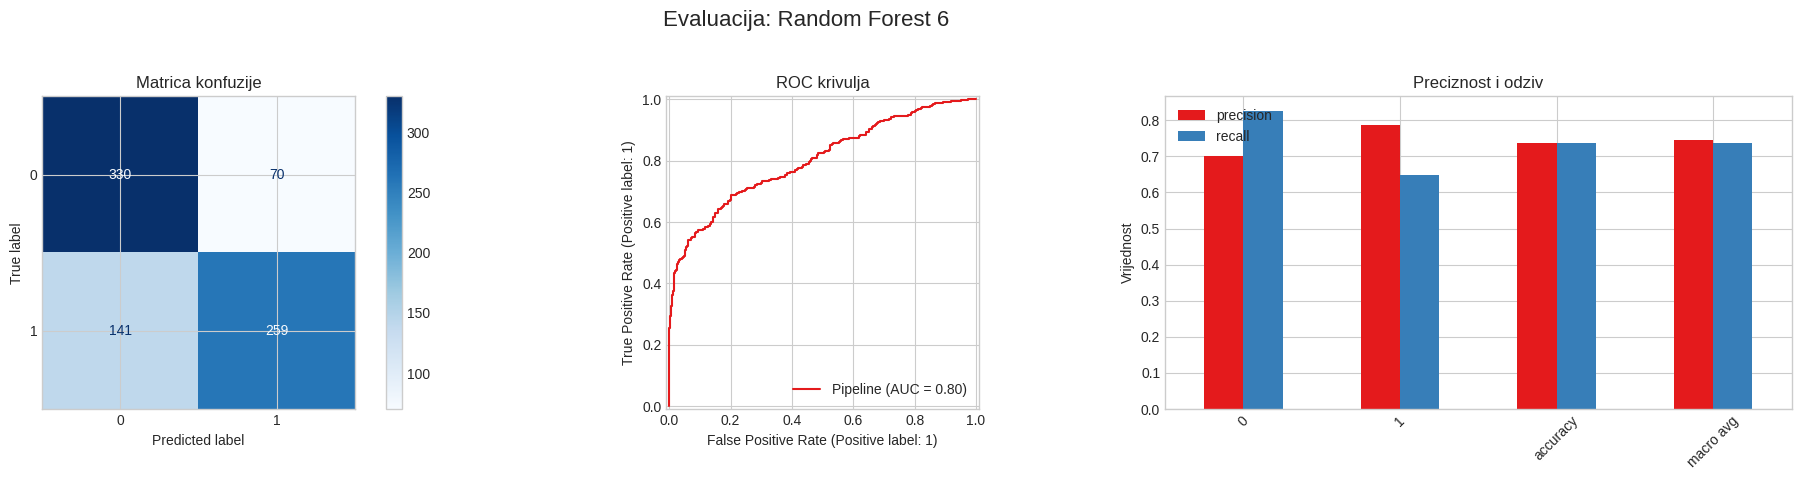

In [ ]:
X = df_binned.drop('Potability', axis=1)
y = df_binned["Potability"]

# Kodiraj kategorijske varijable u brojeve prije SMOTENC-a
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Kategorijske varijable: {categorical_features}")
print(f"Numeričke varijable: {numerical_features}")

# Kodiraj kategorijske varijable
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded = X.copy()

if categorical_features:
    X_encoded[categorical_features] = encoder.fit_transform(X[categorical_features])

# Identifikacija indeksa kategorijskih varijablia
categorical_feature_indices = [X_encoded.columns.get_loc(col) for col in categorical_features]

print("Originalna distribucija:")
print(Counter(y))

# Koristi SMOTENC s indeksima kategorijskih varijabli
smotenc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
X_resampled, y_resampled = smotenc.fit_resample(X_encoded, y)

print("Distribucija nakon SMOTENC-a:")
print(Counter(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Pipeline bez dodatnog preprocessinga jer su podaci već kodirani
pipeline_advanced = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_advanced = {
    'classifier__n_estimators': [ 425, 450,475],
    'classifier__max_depth': [23, 25,27],
    'classifier__min_samples_split': [5,6],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_advanced = GridSearchCV(
    pipeline_advanced,
    param_grid_advanced,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_advanced.fit(X_train, y_train)

# Evaluacija najboljeg modela na test skupu
best_model = grid_search_advanced.best_estimator_
evaluiraj_model(best_model, X_test, y_test, grid_search=grid_search, naziv_modela="Random Forest 6")
prikazi_evaluacijske_grafove(best_model, X_test, y_test, naziv_modela="Random Forest 6")


                  Značajka   Važnost
0                       ph  0.111046
4                  Sulfate  0.097672
1                 Hardness  0.093347
3              Chloramines  0.085751
2                   Solids  0.084635
6           Organic_carbon  0.072940
8                Turbidity  0.071830
5             Conductivity  0.071561
7          Trihalomethanes  0.068346
9                ph_binned  0.039074
12      Chloramines_binned  0.033079
10         Hardness_binned  0.030806
17        Turbidity_binned  0.026811
15   Organic_carbon_binned  0.026059
16  Trihalomethanes_binned  0.023940
11           Solids_binned  0.022534
14     Conductivity_binned  0.021058
13          Sulfate_binned  0.019511


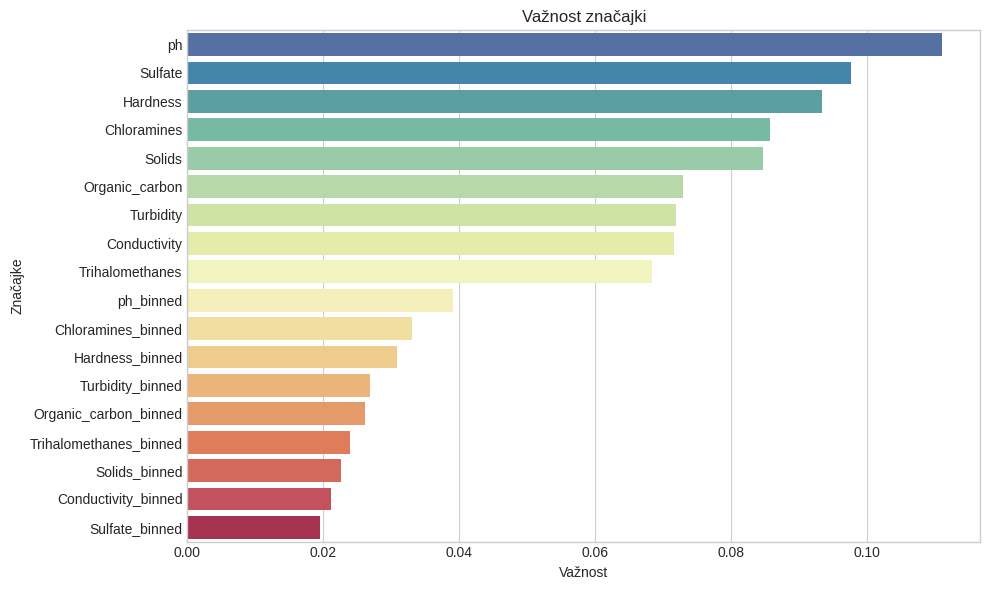

In [ ]:
prikazi_vaznost_znacajki(best_model, X)
prikazi_top_znacajke(best_model, X, palette="Spectral_r",return_data=False)

In [ ]:
trained_classifier = best_model.named_steps['classifier']

one_tree = trained_classifier.estimators_[1]

dot_data = export_graphviz(one_tree, out_file=None, feature_names=X.columns, class_names=['0','1'], filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('decision_tree', cleanup=True)

Image(filename='decision_tree.png')